In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt

### Open JSON File
Clean json data

In [2]:
with open('../input/jobcards-v6/Jobcards.json', "r") as json_file:
    cards_js = json.load(json_file)
    cards_df = pd.read_json(cards_js)
# Drop null
cards_df = cards_df.dropna()

# Replace backspaces with ""
for name in cards_df.columns:
    cards_df[name] = [a.replace("\n", "") for a in cards_df[name]]

# Select city as Location
cards_df["Location"] = [a.split()[0].replace(",", "") for a in cards_df["Location"]]

# Get info DF
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        453 non-null    object
 1   Company      453 non-null    object
 2   Location     453 non-null    object
 3   Description  453 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


In [3]:
# Quick check for "\n"
cards_df.head()

,Title,Company,Location,Description
0,Senior Consultant in Data science ...,Sia Partners,Antwerpen,"As a senior consultant in Data Science, you w..."
1,Stage - Data Science,Argenta,Antwerpen,FunctieKlaar voor een eerste leerri...
2,Data Science Engineer Healthcare ...,Robovision,Gent,Geplaatst door Willem R...
3,Data Science Software Engineer ...,OMP,Gent,"We are OMP, a game changer that opt..."
4,Junior Market Analyst (FMCG) ...,GfK,Leuven,"For over 80 years, GfK has been a r..."


### Split dataframe in Data Engineers, Scientists and Analysits

In [10]:
# Data Scientist
dc_titles = [("scientist" in a) | ("Scientist" in a) | ("science" in a) | ("Science" in a) for a in cards_df["Title"]]
dc_cards = cards_df[dc_titles]

# Data Analyst
da_titles = [("analyst" in a) | ("Analyst" in a) for a in cards_df["Title"]]
da_cards = cards_df[da_titles]

# Data engineers
de_titles = [("engineer" in a) | ("Engineer" in a) for a in cards_df["Title"]]
de_cards = cards_df[de_titles]

# Print amounts
print("Data Scientist jobs: " + str(dc_cards["Title"].count()) + ", Data Engineer jobs:  " + str(de_cards["Title"].count()) + ", Data Analyst jobs:  " + str(da_cards["Title"].count()))

Data Scientist jobs: 53, Data Engineer jobs:  97, Data Analyst jobs:  19


### Location analysis

<AxesSubplot:title={'center':'Data Science job locations'}, xlabel='Location'>

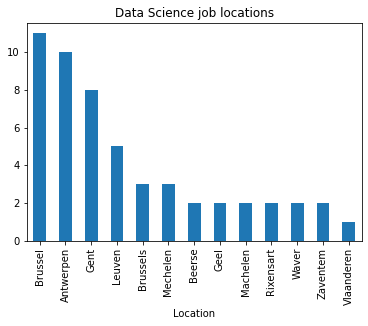

In [11]:
dc_cards.groupby(["Location"])["Title"].count().sort_values(ascending=False).plot(kind="bar", title="Data Science job locations")

<AxesSubplot:title={'center':'Data Engineer job locations'}, xlabel='Location'>

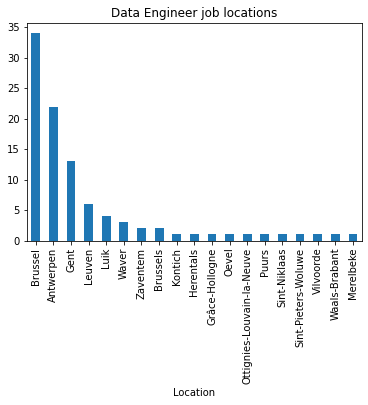

In [13]:
de_cards.groupby(["Location"])["Title"].count().sort_values(ascending=False).plot(kind="bar", title="Data Engineer job locations")

<AxesSubplot:title={'center':'Data Analyst job locations'}, xlabel='Location'>

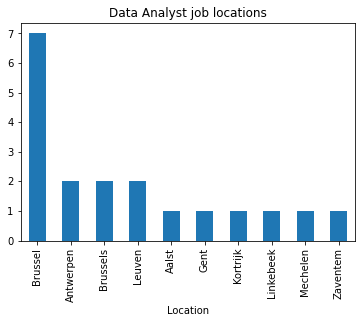

In [12]:
da_cards.groupby(["Location"])["Title"].count().sort_values(ascending=False).plot(kind="bar", title="Data Analyst job locations")